# Q-Learning with Battery Example
Purpose of this notebook is to demonstrate the ability of a reinforcement learning agent based on Q-Learning to learn to control a battery.

In [1]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf

from energy_py import Runner
from energy_py.agents import DQN
from energy_py.envs import BatteryEnv

In [2]:
#  set random seeds for repeatability
np.random.seed(42)
tf.set_random_seed(42)

In [3]:
#  define a total number of steps for the experiment to run
TOTAL_STEPS = 400000

#  to setup the agent we use a dictionary
#  a dictionary allows us to eaisly save the config to csv if we want
agent_config = {'discount': 0.97,                 #  the discount rate
                'tau': 0.001,                     #  parameter that controls the copying of weights from online to target network
                'total_steps': TOTAL_STEPS,   
                'batch_size': 32,                 #  size of the minibatches used for learning
                'layers': (50, 50),               #  structure of the neural network used to approximate Q(s,a)
                'learning_rate': 0.0001,          #  controls the stength of weight updates during learning       
                'epsilon_decay_fraction': 0.3,    #  a fraction as % of total steps where epsilon decayed from 1.0 to 0.1
                'memory_fraction': 0.4,           #  the size of the replay memory as a % of total steps
                'memory_type': 'deque',           #  the replay memory implementation we want
                'process_observation': 'standardizer',
                'process_target': 'normalizer'}    

#  we standardize the observations to keep gradients under control when learning
#  we normalize the batch for the same reasons

#  keep all of the BatteryEnv variables (episode length, efficiency etc) at their defaults
#  we just need to let our env know where our state.csv and observation.csv are (data_path)
env = BatteryEnv(data_path=os.getcwd())

In [4]:
#  Runner is a class that helps us with experiments - tracking rewards, writing environment info to csv and managing TensorBoard
#  in this notebook we just use it to track rewards for us
runner = Runner()

#  initialize Tensorflow machinery
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    #  add the tf session and the environment to the agent config dictionary
    #  and initialize the agent
    agent_config['sess'] = sess
    agent_config['env'] = env
    agent = DQN(**agent_config)
    
    #  initial values for the step and episode number
    step, episode = 0, 0

    #  outer while loop runs through multiple episodes
    while step < TOTAL_STEPS:
        episode += 1
        done = False
        observation = env.reset()
        
        #  inner while loop runs through a single episode
        while not done:
            step += 1
            #  select an action
            action = agent.act(observation)
            
            #  take one step through the environment
            next_observation, reward, done, info = env.step(action)
            
            #  store the experience
            agent.remember(observation, action, reward,
                           next_observation, done)
            
            #  moving to the next time step
            observation = next_observation
            #  saving the reward 
            runner.append(reward)
            
            #  we don't start learning until the memory is half full
            if step > int(agent.memory.size * 0.5):
                train_info = agent.learn()
        
        if episode % 200 == 0:
            print('progress - {:.1f}% - episode {:.0f} - run time {:.2f} - episode reward {:.2f} - avg rewards {:.2f}'.format(100*step/TOTAL_STEPS,
                                                                                                                              episode,
                                                                                                                              runner.calc_time(),
                                                                                                                              sum(runner.ep_rewards),
                                                                                                                              runner.avg_rew))
        #  the report method should be run at the end of each episode
        runner.report({'ep': episode,
                       'step': step})

progress - 2.4% - episode 200 - run time 0.14 - episode reward -0.04 - avg rewards -16.08
progress - 4.7% - episode 400 - run time 0.25 - episode reward 16.58 - avg rewards -18.79
progress - 7.0% - episode 600 - run time 0.37 - episode reward -69.39 - avg rewards -19.39
progress - 9.4% - episode 800 - run time 0.49 - episode reward 8.42 - avg rewards -19.62
progress - 11.8% - episode 1000 - run time 0.63 - episode reward -31.40 - avg rewards -18.25
progress - 14.1% - episode 1200 - run time 0.83 - episode reward -18.20 - avg rewards -24.05
progress - 16.4% - episode 1400 - run time 1.09 - episode reward 35.26 - avg rewards -26.02
progress - 18.8% - episode 1600 - run time 1.42 - episode reward -46.54 - avg rewards -29.27
progress - 21.1% - episode 1800 - run time 2.94 - episode reward -15.53 - avg rewards -20.53
progress - 23.5% - episode 2000 - run time 5.63 - episode reward 2.46 - avg rewards -17.55
progress - 25.9% - episode 2200 - run time 8.38 - episode reward -12.72 - avg rewards

In [5]:
#  energy_py uses TensorBoard for logging - for the scope of this notebook example we will do
#  some plotting using matplotlib

import matplotlib.pyplot as plt

episode_rewards = runner.global_rewards
plt.plot(episode_rewards)

In [6]:
#  we can also look at what happened in our last episode
ep_hist = pd.DataFrame.from_dict(info)
ep_hist.head()

,action,done,electricity_price,gross_rate,losses,net_stored,new_charge,next_observation,next_state,observation,old_charge,reward,state,steps
0,"[1.789473684210526, 1.4736842105263157]",False,50.0,0.315789,0.002632,0.023684,0.023684,"[[50.0, 50.0, 50.0, 100.0, 100.0, 1.0, 1.0, 0....","[[50.0, 0.02368421052631578]]","[[50.0, 50.0, 50.0, 50.0, 100.0, 0.0, 1.0, 0.0]]",0.000000,-1.315789,"[[50.0, 0.0]]",1
1,"[0.10526315789473684, 0.10526315789473684]",False,50.0,0.000000,0.000000,0.000000,0.023684,"[[50.0, 50.0, 100.0, 100.0, 100.0, 2.0, 1.0, 0...","[[50.0, 0.02368421052631578]]","[[50.0, 50.0, 50.0, 100.0, 100.0, 1.0, 1.0, 0....",0.023684,-0.000000,"[[50.0, 0.02368421052631578]]",2
2,"[0.9473684210526315, 1.894736842105263]",False,50.0,-0.284211,0.000000,-0.023684,0.000000,"[[50.0, 100.0, 100.0, 100.0, 100.0, 3.0, 1.0, ...","[[50.0, 0.0]]","[[50.0, 50.0, 100.0, 100.0, 100.0, 2.0, 1.0, 0...",0.023684,1.184211,"[[50.0, 0.02368421052631578]]",3
3,"[0.3157894736842105, 1.263157894736842]",False,50.0,0.000000,0.000000,0.000000,0.000000,"[[100.0, 100.0, 100.0, 100.0, 100.0, 4.0, 1.0,...","[[100.0, 0.0]]","[[50.0, 100.0, 100.0, 100.0, 100.0, 3.0, 1.0, ...",0.000000,-0.000000,"[[50.0, 0.0]]",4
4,"[0.9473684210526315, 1.894736842105263]",False,100.0,0.000000,0.000000,0.000000,0.000000,"[[100.0, 100.0, 100.0, 100.0, -50.0, 5.0, 1.0,...","[[100.0, 0.0]]","[[100.0, 100.0, 100.0, 100.0, 100.0, 4.0, 1.0,...",0.000000,-0.000000,"[[100.0, 0.0]]",5


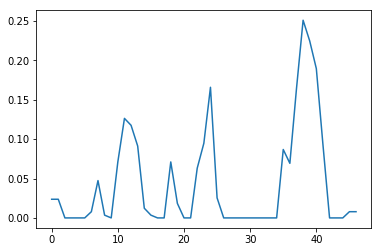

In [7]:
plt.plot(ep_hist.loc[:, 'new_charge'])

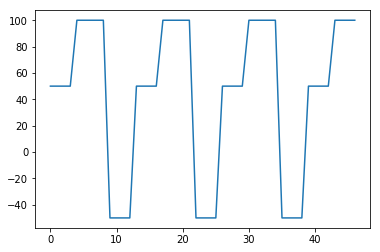

In [8]:
plt.plot(ep_hist.loc[:, 'electricity_price'])

In [9]:
ep_hist.loc[:, 'reward'].sum()

39.649122807017534